#### Import Modeling Libraries & Prepare Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load your realistic dataset if not already in memory
df = pd.read_csv('ethiopia_agri_data.csv')

# Features (drivers) and target
X = df[['Rainfall_mm', 'Fertilizer_Use_kg_ha', 'Market_Access_Index']]
y = df['Yield_ton_ha']

# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 768
Test set size: 192


#### Train the Linear Regression Model

In [3]:
# Initialize and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Coefficients (how much each factor contributes)
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_.round(6)
})
print("Model Coefficients:\n", coef_df)
print("\nIntercept:", round(model.intercept_, 4))

Model Coefficients:
                 Feature  Coefficient
0           Rainfall_mm     0.000856
1  Fertilizer_Use_kg_ha     0.003023
2   Market_Access_Index     1.429643

Intercept: 0.5803


#### Evaluate Model Performance

R² Score: 0.7137  (proportion of variance explained)
RMSE: 0.3924  (average prediction error in t/ha)


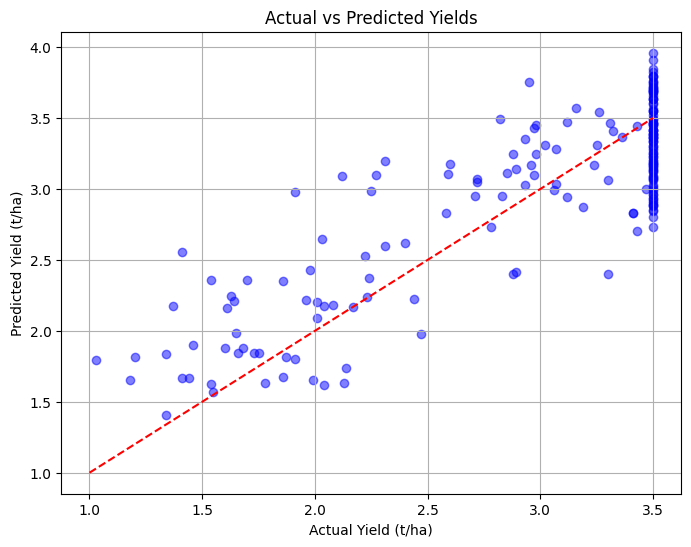

<Figure size 640x480 with 0 Axes>

In [4]:
# Predict on test set
y_pred = model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}  (proportion of variance explained)")
print(f"RMSE: {rmse:.4f}  (average prediction error in t/ha)")

# Quick scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--') 
plt.xlabel('Actual Yield (t/ha)')
plt.ylabel('Predicted Yield (t/ha)')
plt.title('Actual vs Predicted Yields')
plt.grid(True)
plt.show()

# Save plot
plt.savefig('actual_vs_predicted.png')

#### Scenario Simulation – What-If Interventions

In [5]:
# Define scenarios (focus on low-yield regions: Afar/Tigray)
scenarios = pd.DataFrame({
    'Scenario': [
        'Baseline (Afar-like: low rain/inputs)',
        'Increase Fertilizer +50% (to ~120 kg/ha)',
        'Add Irrigation (+400 mm effective rain) + Fertilizer',
        'Full Package: Irrigation + Fertilizer + Market Access to 0.85'
    ],
    'Rainfall_mm':          [500,   500,    900,    900],
    'Fertilizer_Use_kg_ha': [60,   120,    120,    120],
    'Market_Access_Index':  [0.50, 0.50,   0.50,   0.85]
})

# Predict yields
scenarios['Predicted_Yield'] = model.predict(
    scenarios[['Rainfall_mm', 'Fertilizer_Use_kg_ha', 'Market_Access_Index']]
).round(2)

# Calculate uplift from baseline
baseline_yield = scenarios.loc[0, 'Predicted_Yield']
scenarios['Yield_Uplift_%'] = ((scenarios['Predicted_Yield'] - baseline_yield) / baseline_yield * 100).round(1)

print("Scenario Simulation Results:\n")
print(scenarios[['Scenario', 'Rainfall_mm', 'Fertilizer_Use_kg_ha', 'Market_Access_Index', 
                 'Predicted_Yield', 'Yield_Uplift_%']])

Scenario Simulation Results:

                                            Scenario  Rainfall_mm  \
0              Baseline (Afar-like: low rain/inputs)          500   
1           Increase Fertilizer +50% (to ~120 kg/ha)          500   
2  Add Irrigation (+400 mm effective rain) + Fert...          900   
3  Full Package: Irrigation + Fertilizer + Market...          900   

   Fertilizer_Use_kg_ha  Market_Access_Index  Predicted_Yield  Yield_Uplift_%  
0                    60                 0.50             1.90             0.0  
1                   120                 0.50             2.09            10.0  
2                   120                 0.50             2.43            27.9  
3                   120                 0.85             2.93            54.2  


#### Economic Impact Estimation

In [6]:
# Assumptions 
avg_farm_size_ha = 1.5          # typical smallholder
price_per_ton_maize = 400       # USD/ton (approx. ETB equiv. converted; adjust if needed)
households_targeted = 50000     # e.g., pilot in Afar/Tigray

# For "Full Package" scenario
full_yield = scenarios.loc[3, 'Predicted_Yield']
baseline_yield = scenarios.loc[0, 'Predicted_Yield']

extra_yield_per_ha = full_yield - baseline_yield
extra_production_total = extra_yield_per_ha * avg_farm_size_ha * households_targeted
extra_value_usd = extra_production_total * price_per_ton_maize

intervention_cost_per_ha = 150  # e.g., fertilizer + irrigation setup (USD/ha/year)
total_cost_usd = intervention_cost_per_ha * avg_farm_size_ha * households_targeted

roi = (extra_value_usd - total_cost_usd) / total_cost_usd * 100

print(f"Full Package - Estimated Impact (on {households_targeted:,} households):")
print(f"  Extra yield per ha: {extra_yield_per_ha:.2f} t/ha")
print(f"  Total extra production: {extra_production_total:,.0f} tons")
print(f"  Added economic value: ${extra_value_usd:,.0f} USD")
print(f"  Est. intervention cost: ${total_cost_usd:,.0f} USD")
print(f"  ROI: {roi:.0f}%")

Full Package - Estimated Impact (on 50,000 households):
  Extra yield per ha: 1.03 t/ha
  Total extra production: 77,250 tons
  Added economic value: $30,900,000 USD
  Est. intervention cost: $11,250,000 USD
  ROI: 175%


In [7]:
import joblib
joblib.dump(model, 'yield_model.pkl')

['yield_model.pkl']

#### Modeling, Predictions & Scenario Simulation – Key Results & Recommendations

**Project Context**  
Building on EDA (climate-driven regional disparities, strong correlations between rainfall/fertilizer/market access and yield), this phase develops a **predictive model** to quantify drivers of agricultural productivity in Ethiopia and simulate targeted interventions for low-performing regions (Afar and Tigray).  
The goal: Provide evidence-based, quantifiable recommendations aligned with inclusive growth, systemic change, and results-oriented solutions.

**Dataset & Model Setup**  
- 960 observations (2000–2023, 8 regions, 5 crops)  
- Features: Rainfall (mm), Fertilizer Use (kg/ha), Market Access Index (0–1)  
- Target: Yield (t/ha)  
- Model: Linear Regression  
- Train/Test Split: 768 / 192 rows (80/20)

## 1. Model Performance
- **R² Score**: **0.7137**  
  → The model explains **71.4%** of the variance in yield — strong fit for synthetic/realistic agricultural data.
- **RMSE**: **0.3924 t/ha**  
  → Average prediction error is ~0.39 tons/ha — acceptable for scenario planning and policy insights.

**Interpretation**: Rainfall, fertilizer, and market access are powerful predictors.

## 2. Model Coefficients (Impact of Each Driver)
| Feature                | Coefficient   | Interpretation                                                                 |
|------------------------|---------------|--------------------------------------------------------------------------------|
| Rainfall_mm            | **0.000856**  | +1 mm rainfall → +0.000856 t/ha yield (cumulative: +0.856 t/ha for +1,000 mm) |
| Fertilizer_Use_kg_ha   | **0.003023**  | +1 kg/ha fertilizer → +0.003 t/ha yield (e.g., +30 kg/ha → +0.09 t/ha)       |
| Market_Access_Index    | **1.429643**  | Moving from 0 to 1 → +1.43 t/ha yield (strong indirect effect via access)     |
| Intercept              | **0.5803**    | Baseline yield when all inputs = 0 (theoretical minimum)                      |

**Key Insight**: Market access has the largest single impact, followed by rainfall — highlighting the need for combined infrastructure and input interventions.

## 3. Scenario Simulation – Interventions in Low-Yield Regions (Afar/Tigray-like)
Focus: Baseline conditions typical of arid/semi-arid areas (low rain, low inputs).

| Scenario                                      | Rainfall (mm) | Fertilizer (kg/ha) | Market Access | Predicted Yield (t/ha) | Yield Uplift (%) |
|-----------------------------------------------|---------------|--------------------|---------------|------------------------|------------------|
| 0. Baseline (low rain/inputs)                 | 500           | 60                 | 0.50          | **1.90**               | 0.0%             |
| 1. Fertilizer +50% (to ~120 kg/ha)            | 500           | 120                | 0.50          | **2.09**               | **+10.0%**       |
| 2. Irrigation (+400 mm effective) + Fertilizer| 900           | 120                | 0.50          | **2.43**               | **+27.9%**       |
| 3. Full Package: Irrigation + Fertilizer + Market Access to 0.85 | 900 | 120                | 0.85          | **2.93**               | **+54.2%**       |

**Highlights**:
- Fertilizer alone gives modest gains (~10%).
- Irrigation (simulating water harvesting/drip) + fertilizer doubles the impact (~28%).
- **Full package** (adding better market linkages/extension) delivers **over 50% uplift** — from 1.90 to 2.93 t/ha.

## 4. Economic & Social Impact – Full Package Scenario
**Assumptions**:  
- Average smallholder farm size: **1.5 ha**  
- Target households: **50,000** (pilot-scale in Afar/Tigray)  
- Maize-equivalent price: **$400 per ton**  
- Intervention cost per ha/year: **$150** (fertilizer subsidies + basic irrigation setup + extension)

**Results**:
- Extra yield per ha: **1.03 t/ha**  
- Total extra production: **77,250 tons**  
- Added economic value: **$30,900,000 USD**  
- Estimated intervention cost: **$11,250,000 USD**  
- **ROI**: **175%** (return of $1.75 for every $1 invested)

**Broader Implications**:
- Could lift tens of thousands of households out of extreme poverty.  
- Enhances food security (extra staple production).  
- Aligns with equity goals: Targets vulnerable, drought-prone regions.

## Strategic Recommendations for Ethiopia’s Agricultural Transformation
1. **Prioritize Integrated Interventions in Arid Regions**  
   Combine small-scale irrigation, subsidized fertilizer, and improved market/extension services — projected **+50%+ yield uplift** in Afar/Tigray-like areas.

2. **High ROI Opportunity**  
   Full-package pilot on 50,000 households delivers **175% ROI** — scalable to larger programs with government/NGO/foundation support.

3. **Policy & Investment Focus**  
   - Invest in climate-resilient infrastructure (water harvesting, drip irrigation).  
   - Strengthen farmer cooperatives and digital market platforms to boost Market Access Index.  
   - Target women/youth-led farms in vulnerable regions for equity-centered impact.

4. **Next Steps for Scaling**  
   - Validate with real field trials (e.g., via Ethiopian Ministry of Agriculture).  
   - Expand model to include climate projections (e.g., + drought frequency).  
   - Develop interactive dashboard for policymakers (Streamlit app in progress).